A partir du site internet [data.gouv](https://www.data.gouv.fr/fr/datasets/emplacements-dimplantation-de-cameras-de-videoprotection-bo-ville-de-paris-du-01-02-2019/), nous mettons en place une API pour récuperer les données (en version beta lors de l'écriture du présent).
Nous récupérons l'ID du jeu de données (ici : 0f195145-1f5a-4762-9edc-40031ba4402f).

In [1]:
import pandas as pd
import geopandas as gpd
import requests

#Création du point d'accès
api_root = "https://tabular-api.data.gouv.fr/api/resources/"
ID_datagouv = "0f195145-1f5a-4762-9edc-40031ba4402f"
url_api = api_root + ID_datagouv + "/data/"
print(url_api)

#Récupération des données sous format Json (plusieurs pages sont à parcourirs)

def recuperation_data(url_api):
    df = []  # Liste pour accumuler les données
    current_url = url_api

    while current_url:
        req = requests.get(current_url)
        wb = req.json()
        df.extend(wb['data'])
        current_url = wb["links"].get("next")
    return pd.DataFrame(df)

df = recuperation_data(url_api)

# Convertir les coordonnées en objets géométriques (de lon, lat à des points)
geometry = gpd.GeoSeries.from_xy(df.lon, df.lat)
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs('EPSG:4326', inplace=True)  # On identifi le CRS WGS 84, à vérifier toutefois

print(gdf.head(5))


https://tabular-api.data.gouv.fr/api/resources/0f195145-1f5a-4762-9edc-40031ba4402f/data/
   __id Code postal Numéro                                       Implantation  \
0     1       75001   1051                     Rue Saint-Denis, rue de Rivoli   
1     2       75001   1055                     Rue Montmartre, rue de Turbigo   
2     3       75001   1056                    Rue Montorgueil, rue de Turbigo   
3     4       75001   1057  Quai François Mitterrand, rue de l'Amiral de C...   
4     5       75002   2006                Boulevard des Capucines, rue Scribe   

  Précision de l’implantation Date de mise en service       lon        lat  \
0                  croisement                08/07/16  2.347502  48.858750   
1                  croisement                10/03/17  2.346124  48.863243   
2                  croisement                10/03/17  2.346291  48.863273   
3                  croisement                08/06/18  2.339848  48.858990   
4                  croisement    

In [2]:
gdf.shape

(707, 9)

Nous projetons désormais les points sur une carte de Paris en utilisant un fond de carte par le biais de cartiflette.

<Axes: title={'center': 'Arrondissements de Paris'}>

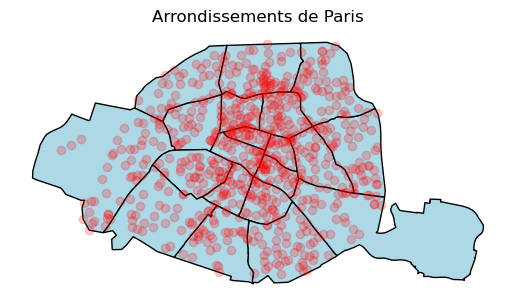

In [8]:
import matplotlib.pyplot as plt
from cartiflette import carti_download

#Importation de la carte des arrondissement et création du fond de carte

arr_borders = carti_download(
    crs=4326,
    values=["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

base = arr_borders.plot(color="lightblue", edgecolor="black")
base.set_axis_off()
base.set_title("Arrondissements de Paris")


#Intégration de la localisation des caméras de surveillance
gdf.plot(ax=base, color = "red", alpha = 0.2)


